In [111]:
import genjax
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

key = jax.random.PRNGKey(0)

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["animation.embed_limit"] = 25

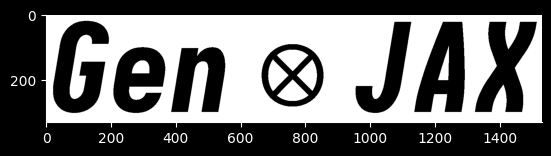

In [128]:
# Load the image
im = mpimg.imread("../../../docs/assets/img/logo.png")

# Convert to mask
im = np.amax(im[:, :, :2], 2) < 0.9
# invert the image
im = np.logical_not(im)

# Convert back to float
im = im.astype(float)
height, width = im.shape
# plot the image
plt.imshow(im, cmap="gray")
plt.show()

In [122]:
# Define the prior model
@genjax.gen
def prior_model():
    x = genjax.uniform(0.0, float(height)) @ "x"
    y = genjax.uniform(0.0, float(width)) @ "y"
    obs_x = genjax.normal(x, 1.0) @ "obs_x"
    obs_y = genjax.normal(y, 1.0) @ "obs_y"
    return x, y


jax_im = jnp.array(im.astype(float))
n_samples = 5000
batched_prior_model = prior_model.repeat(n=n_samples)

key, subkey = jax.random.split(key)
tr = batched_prior_model.simulate(subkey, ())
xs_init, ys_init = tr.get_choices()[..., "x"], tr.get_choices()[..., "y"]
zs_init = np.stack([xs_init, ys_init], axis=1)

In [116]:
# by changing this, we should be able to change the visual effect for convergence of the particles to the true distribution
@genjax.gen
def proposal1(z):
    x, y = z
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y

# v2: rotating proposal distribution
@genjax.gen
def proposal2(z):
    x, y = z
    theta = 0.3
    x, y = x*cos(theta) - y*sin(theta), x*sin(theta) + y*cos(theta)
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y

# v3: spiraling inwards proposal distribution
@genjax.gen
def proposal3(z):
    x, y = z
    theta = 0.3
    inward_coeff = (x+y) / 2
    x, y = (x*cos(theta) - y*sin(theta), x*sin(theta) + y*cos(theta))*inward_coeff
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y

In [124]:
# Creating observation
# TODO: what do I actually want here?
def make_observations(xs, ys):
    obs = jax.vmap(lambda idx: C["data", idx, "y"].set(ys[idx]))(ys)
    return obs

chm = make_observations(im)

# Getting samples using proposal1 and naive importance sampling
# target_posterior = genjax.Target(batched_prior_model, 

TypeError: make_observations() missing 1 required positional argument: 'ys'

In [ ]:
plt.style.use("dark_background")
animation.embed_limit = 25
fig, ax = plt.subplots()
fig.tight_layout()

ax.set_axis_off()
ax.set_xlim(0, width)
ax.set_ylim(0, height)

scat = ax.scatter(ys_init, height - xs_init, s=1000 * 1 / n_samples)

In [ ]:
n_frames = 2
samples = jnp.array([zs_init, zs_init + 1])
weights = np.ones(n_samples) / n_samples


# create an animation for the particles
def animate(i):
    scat.set_offsets(np.c_[samples[i, :, 1], height - samples[i, :, 0]])
    scat.set_sizes(1000 * weights[i])
    return (scat,)


# create an animation for the particles
ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=n_frames, blit=True, interval=100
)